In [26]:
%matplotlib inline
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

In [27]:
df = pd.read_csv( './train_preprocessed.csv' )

In [28]:
# Create a validation set, with last 20% of data
num_val = int( len(df) * 0.2 )

ylog = np.log1p( df['price_doc'].values )
df.drop( ['price_doc'], axis = 1, inplace = True )
X = df.values
X_train = X[ :-num_val ]
X_val = X[ -num_val: ]
ylog_train = ylog[ :-num_val ]
ylog_val = ylog[ -num_val: ]

print('X shape is', X.shape)
print('X_train shape is', X_train.shape)
print('y_train shape is', ylog_train.shape)
print('X_val shape is', X_val.shape)
print('y_val shape is', ylog_val.shape)

('X shape is', (30471L, 311L))
('X_train shape is', (24377L, 311L))
('y_train shape is', (24377L,))
('X_val shape is', (6094L, 311L))
('y_val shape is', (6094L,))


In [31]:
dtrain = xgb.DMatrix(X_train, ylog_train, feature_names=df.columns)
dval = xgb.DMatrix(X_val, ylog_val, feature_names=df.columns)

In [32]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

# Uncomment to tune XGB `num_boost_rounds`
partial_model = xgb.train(xgb_params, dtrain, num_boost_round=1000, evals=[(dval, 'val')],
                       early_stopping_rounds=20, verbose_eval=20)

num_boost_round = partial_model.best_iteration

[0]	val-rmse:14.4764
Will train until val-rmse hasn't improved in 20 rounds.
[20]	val-rmse:5.27175
[40]	val-rmse:1.99391
[60]	val-rmse:0.868492
[80]	val-rmse:0.535102
[100]	val-rmse:0.45526
[120]	val-rmse:0.434016
[140]	val-rmse:0.427694
[160]	val-rmse:0.425108
[180]	val-rmse:0.423896
[200]	val-rmse:0.423605
[220]	val-rmse:0.422986
[240]	val-rmse:0.422784
[260]	val-rmse:0.422655
[280]	val-rmse:0.422775
Stopping. Best iteration:
[269]	val-rmse:0.422429



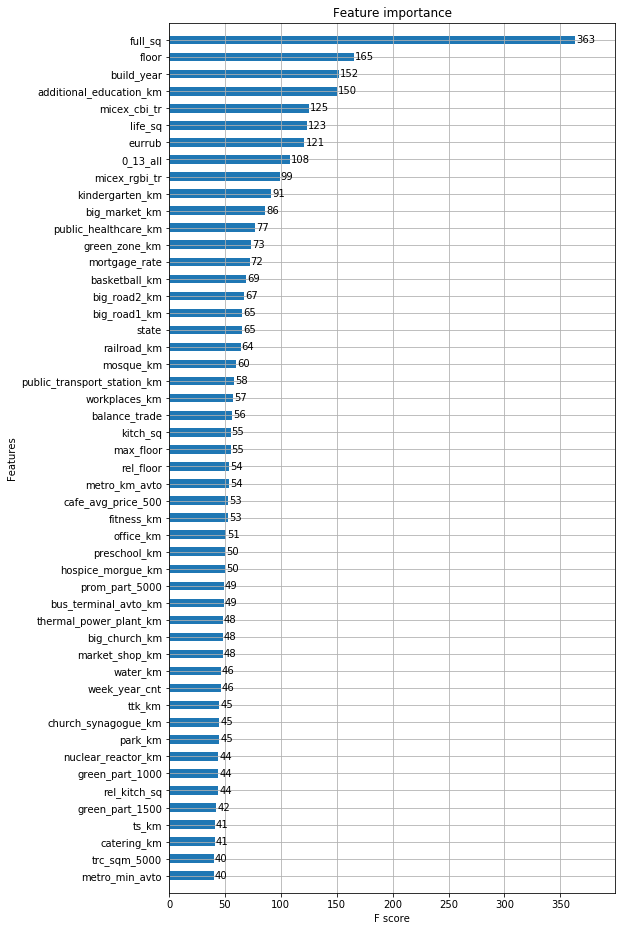

In [33]:
# Строим диаграмму важности признаков
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance( partial_model, height=0.5, ax=ax, max_num_features = 50 )

In [34]:
# Обучаемся на всей выборке.
num_boost_round = partial_model.best_iteration
model = xgb.train(dict(xgb_params, silent=0), 
                  xgb.DMatrix(X, ylog, feature_names=df.columns), 
                  num_boost_round = num_boost_round)

In [35]:
# Сохраняем модель
model.save_model( './model' )